In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
sns.set()
# ML Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
import xgboost as xgb
# tune
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, STATUS_FAIL
from mlflow.sklearn import log_model, save_model
from mlflow.tracking import MlflowClient
import mlflow.xgboost
import mlflow.sklearn
import mlflow
from mlflow.models.signature import infer_signature
from urllib.parse import urlparse
import shap
import logging
import sys
import warnings
import traceback

/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:

## data loading
df = pd.read_csv('data/php_data_all.csv', index_col=0)
# selecting data according to temperature range
# NOTE: Data selected between [300, 355]
df = df[(df['Te[K]'] > 300) & (df['Te[K]'] < 355)]


# TP Prediction

In [3]:
## data split
x = df[['Tc[K]', 'TR[K/W]', 'Fluid', 'FR']]
y = df[['Te[K]', 'P[bar]', 'Q[W]']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## data pipeline preparation
numeric_features = ['Tc[K]', 'TR[K/W]', 'FR']
categorical_features = ['Fluid']

numeric_transformer = make_pipeline(StandardScaler())
categorical_tranformer = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_tranformer, categorical_features)
    ])


## a function to evaluate a trained ML model
def evaluate(y_test, y_pred, k=6):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = y_test.shape[0]
    k = k
    r2_adj = 1 - (((1-r2)*(n-1)) / (n-k-1))
    return rmse, mae, r2, r2_adj

In [4]:
## objective of a ML model training
# mlflow manual logging of metrics and model
experiment_name = 'CLPHP_TP_Prediction'
mlflow.set_experiment(experiment_name)
## Model dictionary
models = [
    {
        'name': 'XGBoost',
        'model': xgb.XGBRegressor,
        'search_space': {
            'eta': hp.uniform('eta', 0.1, 1),
            'max_depth': hp.randint('max_depth', 2, 5)
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor,
        'search_space': {
            'n_estimators': hp.randint('n_estimators', 11, 101),
            'max_depth': hp.randint('max_depth', 2, 20)
        }
    },
    # {
    #     'name': 'Linear Regression',
    #     'model': LinearRegression,
    #     'search_space': {}  # No hyperparameters for Linear Regression
    # },
    {
        'name': 'Elastic Net',
        'model': ElasticNet,
        'search_space': {
            'alpha': hp.uniform('alpha', 0.1, 1),
            'l1_ratio': hp.uniform('l1_ratio', 0.1, 0.9)
        }
    },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingRegressor,
        'search_space': {
            'n_estimators': hp.randint('n_estimators', 50, 150),
            'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
            'max_depth': hp.randint('max_depth', 2, 10)
        }
    },
    {
        'name': 'Support Vector Machine',
        'model': SVR,
        'search_space': {
            'C': hp.loguniform('C', -5, 2),
            'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly']),
            'degree': hp.randint('degree', 2, 5)
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'model': KNeighborsRegressor,
        'search_space': {
            'n_neighbors': hp.randint('n_neighbors', 3, 20),
            'weights': hp.choice('weights', ['uniform', 'distance']),
            'p': hp.choice('p', [1, 2])
        }
    }
]

In [5]:
# all_predictions = {}
best_models = []
# Loop through the list of models and train/tune each model
for model_info in models:
    model_name = model_info['name']
    model_class = model_info['model']
    search_space = model_info['search_space']

    def objective(params):
        try:
            # Check if there is an active run and end it
            if mlflow.active_run() is not None:
                mlflow.end_run()
                
            with mlflow.start_run(run_name=f'{model_name}_run'):
                mlflow.set_tag('model', model_name)
                mlflow.log_params(params=params)

                # data pipeline
                if search_space:
                    model = model_class(**params)
                else:
                    model = model_class()

                data_pipeline = Pipeline(steps=[('Preprocessing', preprocessor), 
                                                (model_name, model)])
                
                # cross validation
                cv_scores = cross_val_score(data_pipeline, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
                avg_cv_rmse = np.sqrt(-cv_scores.mean())
                mlflow.log_metric('avg_cv_rmse', avg_cv_rmse)
                
                # training
                data_pipeline.fit(x_train, y_train)

                # train and test prediction
                #pred_train = data_pipeline.predict(x_train)
                pred = data_pipeline.predict(x_test)
                rmse, mae, r2, r2_adj = evaluate(y_test=y_test, y_pred=pred)
                signature = infer_signature(x_train, pred)

                # # collecting pred
                # all_predictions[model_name] = {'true_labels': y_test,
                #                                'predicted_labels': pred}

                # test
                mlflow.log_metric('rmse', rmse)
                mlflow.log_metric('mae', mae)
                mlflow.log_metric('r2', r2)
                mlflow.log_metric('r2_adj', r2_adj)
                
                mlflow.sklearn.log_model(
                    sk_model=model,
                    artifact_path=f"{model_name.lower()}-model-tp",
                    signature=signature,
                    registered_model_name=f"{model_name.lower()}-regressor-tp",
                )
            
            return  {'loss': rmse, 'status': STATUS_OK}
        
        except Exception as err:
            # Log the error and continue to the next model
            print(f"Error occurred for {model_name}: {str(err)}")
            traceback.print_exc()  # Print detailed error traceback
            return {'loss': float('inf'), 'status': STATUS_FAIL}  # Set a high loss value to minimize impact on optimization

    try:
        if search_space:
            # Hyperparameter tuning
            best_results = fmin(fn=objective, 
                                space=search_space, 
                                algo=tpe.suggest, 
                                max_evals=10, 
                                trials=Trials())
            
            # Get the best model based on the best_results or other criteria
            best_model = model_class(**best_results)

            # Log hyperparameters of the best model
            mlflow.log_params(params=best_results)
        else:
            best_model = model_class()
            
        # Tag the best model with additional information
        #mlflow.set_tag('best_model_name', model_name)

        best_models.append((model_name, best_model))
        
        # # Get the best model based on the best_results or other criteria
        # best_model = model_class(**best_results)

        # Save the best model (this may vary based on the model serialization method you are using)
        save_model(best_model, f"best_{model_name.lower()}_model_tp")

        # Register the model in the Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/best_{model_name.lower()}_model_tp"
        mlflow.register_model(model_uri, f"{model_name.lower()}-regressor-tp")

        # Log the best model with hyperparameters
        mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path=f"{model_name.lower()}-model-tp",
        #signature=signature,
        registered_model_name=f"{model_name.lower()}-regressor-tp",
    )
    except Exception as err:
        # Log the error and continue to the next model
        print(f"Error occurred during hyperparameter tuning for {model_name}: {str(err)}")
        traceback.print_exc()  # Print detailed error traceback
        continue  # Continue to the next iteration of the loop

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



 10%|█         | 1/10 [00:02<00:19,  2.16s/trial, best loss: 6.0345290114932215]

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '12' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



 20%|██        | 2/10 [00:03<00:13,  1.74s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '13' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 30%|███       | 3/10 [00:05<00:11,  1.66s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '14' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 40%|████      | 4/10 [00:06<00:09,  1.55s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '15' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 50%|█████     | 5/10 [00:08<00:07,  1.58s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '16' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 60%|██████    | 6/10 [00:09<00:06,  1.52s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '17' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 70%|███████   | 7/10 [00:11<00:04,  1.51s/trial, best loss: 6.0345290114932215]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '18' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 80%|████████  | 8/10 [00:12<00:03,  1.52s/trial, best loss: 5.98888384300835]  

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '19' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

 90%|█████████ | 9/10 [00:14<00:01,  1.57s/trial, best loss: 5.98888384300835]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '20' of model 'xgboost-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integ

100%|██████████| 10/10 [00:15<00:00,  1.57s/trial, best loss: 5.98888384300835]
Error occurred during hyperparameter tuning for XGBoost: Path 'best_xgboost_model_tp' already exists and is not empty
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'xgboost-regressor-tp' already exists. Creating a new version of this model...
Created version '21' of model 'xgboost-regressor-tp'.
Traceback (most recent call last):
  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 93, in <module>
    save_model(best_model, f"best_{model_name.lower()}_model_tp")
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/mlflow/sklearn/__init__.py", line 242, in save_model
    _validate_and_prepare_target_save_path(path)
  File "/Users/nirmal/Documents

 10%|█         | 1/10 [00:02<00:24,  2.71s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '13' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 20%|██        | 2/10 [00:04<00:16,  2.04s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '14' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 30%|███       | 3/10 [00:05<00:12,  1.80s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '15' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 40%|████      | 4/10 [00:07<00:10,  1.73s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '16' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 50%|█████     | 5/10 [00:09<00:09,  2.00s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '17' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 60%|██████    | 6/10 [00:11<00:07,  1.76s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '18' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 70%|███████   | 7/10 [00:12<00:05,  1.67s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '19' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 80%|████████  | 8/10 [00:14<00:03,  1.67s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '20' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

 90%|█████████ | 9/10 [00:16<00:01,  1.75s/trial, best loss: 5.712763529274208]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '21' of model 'random forest-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can d

100%|██████████| 10/10 [00:18<00:00,  1.81s/trial, best loss: 5.712763529274208]
Error occurred during hyperparameter tuning for Random Forest: Path 'best_random forest_model_tp' already exists and is not empty
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'random forest-regressor-tp' already exists. Creating a new version of this model...
Created version '22' of model 'random forest-regressor-tp'.
Traceback (most recent call last):
  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 93, in <module>
    save_model(best_model, f"best_{model_name.lower()}_model_tp")
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/mlflow/sklearn/__init__.py", line 242, in save_model
    _validate_and_prepare_target_save_path(path)
  File "/Users/nirm

 10%|█         | 1/10 [00:01<00:10,  1.13s/trial, best loss: 9.933270789063632]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '13' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 20%|██        | 2/10 [00:02<00:09,  1.18s/trial, best loss: 9.933270789063632]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '14' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 30%|███       | 3/10 [00:03<00:08,  1.20s/trial, best loss: 9.933270789063632]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '15' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 40%|████      | 4/10 [00:04<00:06,  1.16s/trial, best loss: 9.933270789063632]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '16' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 50%|█████     | 5/10 [00:05<00:05,  1.14s/trial, best loss: 9.85913289646435] 

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '17' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 60%|██████    | 6/10 [00:07<00:04,  1.21s/trial, best loss: 9.748175195043757]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '18' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 70%|███████   | 7/10 [00:08<00:03,  1.17s/trial, best loss: 9.748175195043757]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '19' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 80%|████████  | 8/10 [00:09<00:02,  1.15s/trial, best loss: 9.748175195043757]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '20' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

 90%|█████████ | 9/10 [00:10<00:01,  1.14s/trial, best loss: 9.748175195043757]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '21' of model 'elastic net-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can decla

100%|██████████| 10/10 [00:11<00:00,  1.16s/trial, best loss: 9.748175195043757]
Error occurred during hyperparameter tuning for Elastic Net: Path 'best_elastic net_model_tp' already exists and is not empty
Error occurred for Gradient Boosting:                 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'elastic net-regressor-tp' already exists. Creating a new version of this model...
Created version '22' of model 'elastic net-regressor-tp'.
Traceback (most recent call last):
  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 93, in <module>
    save_model(best_model, f"best_{model_name.lower()}_model_tp")
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/mlflow/sklearn/__init__.py", line 242, in save_model
    _validate_and_prepare_target_save_path(path)
  File "/Users/nirmal/D

Error occurred for Gradient Boosting:                            
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_

Traceback (most recent call last):

  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 29, in objective
    cv_scores = cross_val_score(data_pipeline, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 328, in cross_validate
    _warn_or_raise_about_fit_failures(results, error_score)

  File 

Error occurred for Support Vector Machine:                       
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_

Traceback (most recent call last):

  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 29, in objective
    cv_scores = cross_val_score(data_pipeline, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 328, in cross_validate
    _warn_or_raise_about_fit_failures(results, error_score)

  File 

 10%|█         | 1/10 [00:01<00:10,  1.12s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '13' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 20%|██        | 2/10 [00:02<00:09,  1.19s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '14' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 30%|███       | 3/10 [00:03<00:08,  1.20s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '15' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 40%|████      | 4/10 [00:04<00:07,  1.20s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '16' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 50%|█████     | 5/10 [00:05<00:05,  1.20s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '17' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 60%|██████    | 6/10 [00:07<00:04,  1.20s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '18' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 70%|███████   | 7/10 [00:08<00:03,  1.18s/trial, best loss: 5.671090371168994]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '19' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 80%|████████  | 8/10 [00:09<00:02,  1.16s/trial, best loss: 5.622109131901505]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '20' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

 90%|█████████ | 9/10 [00:10<00:01,  1.21s/trial, best loss: 5.622109131901505]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '21' of model 'k-nearest neighbors-regressor-tp'.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternativel

100%|██████████| 10/10 [00:11<00:00,  1.19s/trial, best loss: 5.622109131901505]
Error occurred during hyperparameter tuning for K-Nearest Neighbors: Path 'best_k-nearest neighbors_model_tp' already exists and is not empty


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

Setuptools is replacing distutils.

Registered model 'k-nearest neighbors-regressor-tp' already exists. Creating a new version of this model...
Created version '22' of model 'k-nearest neighbors-regressor-tp'.
Traceback (most recent call last):
  File "/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_15505/4165508246.py", line 93, in <module>
    save_model(best_model, f"best_{model_name.lower()}_model_tp")
  File "/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/mlflow/sklearn/__init__.py", line 242, in save_model
    _validate_and_prepare_target_save_path(path)
  File 

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


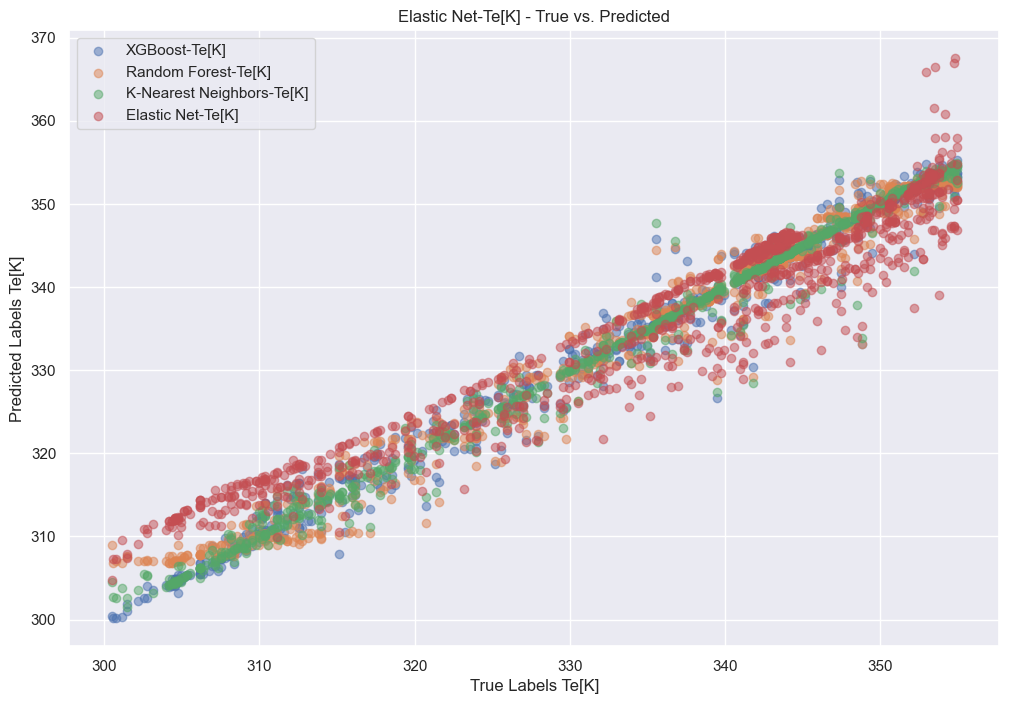

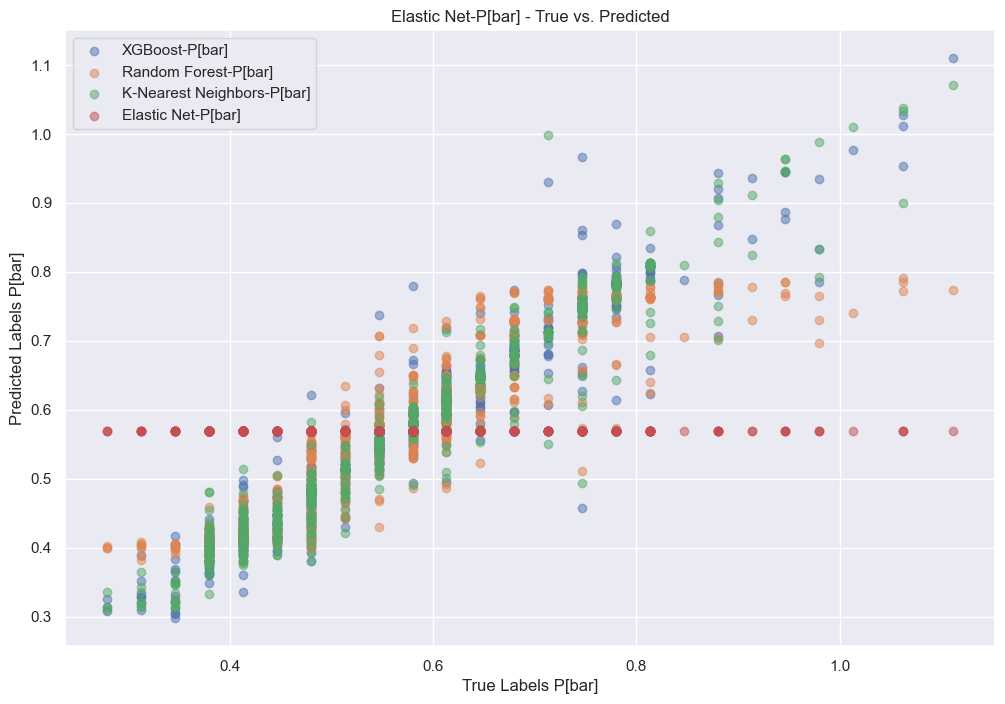

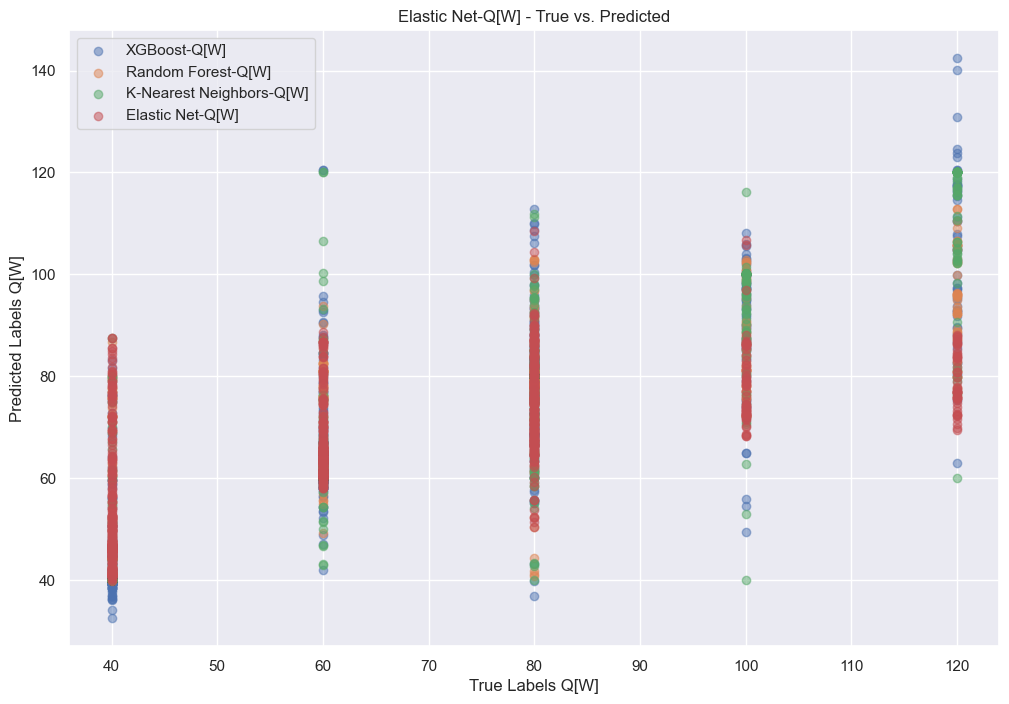

,Model,RMSE,MAE,R2,R2-adj,Param
0,XGBoost,1.817986,1.030403,0.985694,0.985603,Te[K]
1,XGBoost,0.035698,0.021491,0.934839,0.934426,P[bar]
2,XGBoost,11.483765,6.344544,0.743972,0.742350,Q[W]
3,Random Forest,2.240621,1.515471,0.978269,0.978131,Te[K]
4,Random Forest,0.053402,0.037970,0.854180,0.853256,P[bar]
5,Random Forest,11.983150,6.284026,0.721221,0.719455,Q[W]
6,Elastic Net,4.414340,3.543551,0.915652,0.915118,Te[K]
7,Elastic Net,0.139893,0.115620,-0.000670,-0.007010,P[bar]
8,Elastic Net,16.516910,11.751554,0.470366,0.467011,Q[W]
9,K-Nearest Neighbors,1.603668,0.628303,0.988868,0.988798,Te[K]


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn


# Create a DataFrame to store RMSE and R2 scores
results_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2', 'R2-adj'])

# Lists to store predictions and corresponding model names
frames = []
cols = []

# Loop through the best models
for model_name, best_model in best_models:
    # Load the best model from the MLflow registry
    loaded_model = mlflow.sklearn.load_model(f"models:/{model_name.lower()}-regressor-tp/1")

    # Assuming x_test and y_test are already defined
    x_test_ = preprocessor.transform(x_test)  # Use transform instead of fit_transform for the test set
    predictions = loaded_model.predict(x_test_)

    for i in range(y_test.shape[1]):
        # Evaluate the predictions
        rmse, mae, r2, r2_adj = evaluate(y_test=np.array(y_test.iloc[:, i]), y_pred=predictions[:, i])

        # Append results to the DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({'Model': [model_name], 'RMSE': [rmse], 'MAE': [mae], 'R2': [r2], 'R2-adj': [r2_adj], 'Param': y_test.columns[i]})], ignore_index=True)

    # Append predictions and model names to the lists
    frames.append(pd.DataFrame(predictions, columns=[f'{model_name}-Te[K]', f'{model_name}-P[bar]', f'{model_name}-Q[W]']))
    cols.append(model_name)


# Concatenate predictions into a single DataFrame
y_ = pd.concat(frames, axis=1)

# Log the results DataFrame in MLflow
# mlflow.log_param("num_models", len(best_models))
# mlflow.log_artifact(results_df.to_csv(index=False), "results.csv")


params = ['Te[K]', 'P[bar]', 'Q[W]']
for param in params:
    plt.figure(figsize=(12,8))
    for model_name in y_[[f'XGBoost-{param}', f'Random Forest-{param}', f'K-Nearest Neighbors-{param}', f'Elastic Net-{param}']]:
        # Visualize true labels vs. predicted labels
        plt.scatter(y_test[param], y_[model_name], alpha=0.5, label=f'{model_name}')
        
    plt.title(f'{model_name} - True vs. Predicted')
    plt.xlabel(f'True Labels {param}')
    plt.ylabel(f'Predicted Labels {param}')
    plt.legend()
    plt.savefig(f'data/php_{param}_TP')
    plt.show()

# Print the results DataFrame
display(results_df)